In [572]:
import numpy as np
import matplotlib.pyplot as plt
import librosa

In [573]:
y, sr = librosa.load("query/rigby_original.mp3", sr=44100)  
SONG_ID = 3 # fixed song id for this song
print(f"Shape: {y.shape}, Sample Rate: {sr}")

Shape: (1429103,), Sample Rate: 44100


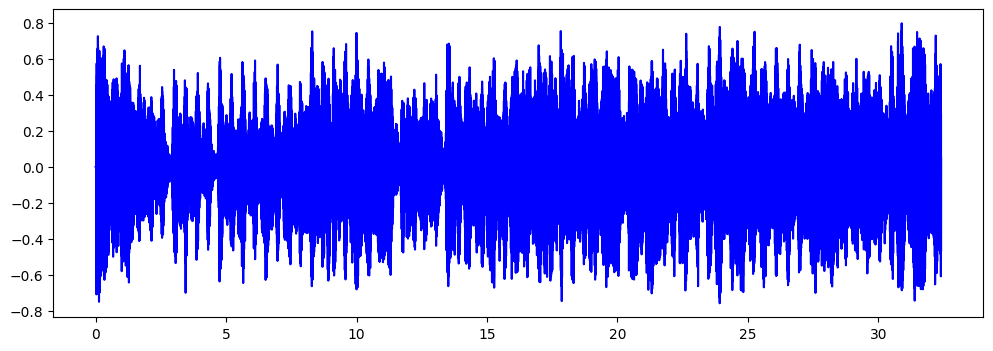

In [574]:
time = np.linspace(0, len(y)/sr, len(y)) # start, stop, no of points
plt.figure(figsize=(12, 4))
plt.plot(time, y, color='blue')
plt.show()

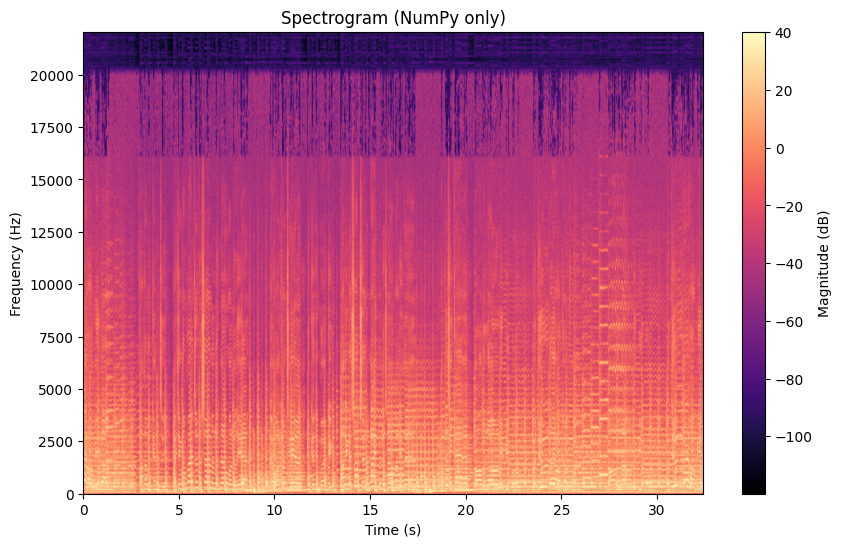

In [575]:
frame_size = 1024 # sampling size

# hop size means each frame overlaps the other frames by 512 samples
hop_size = 512 # step size = (frame_size - hop_size)

window = np.hanning(frame_size) # tapering the edges, we can also use some other windowing method
# hanning = 0.5 - 0.5cos(2*pi*n/N-1)

num_frames = 1 + (len(y) - frame_size) // hop_size

# Allocate spectrogram array
spec = np.zeros((frame_size // 2, num_frames))

for i in range(num_frames):
    start = i * hop_size 
    frame = y[start:start+frame_size] # slice out the frame 
    frame = frame * window # apply Hanning window
    fft_result = np.fft.fft(frame) # compute the FFT
    mag = np.abs(fft_result[:frame_size // 2]) # Take magnitude (only positive freqs)
    
    spec[:, i] = mag

# converting to db
spec_db = 20 * np.log10(spec + 1e-6) # convert to decibels

# Plot
plt.figure(figsize=(10, 6))
plt.imshow(spec_db, origin="lower", aspect="auto", cmap="magma", 
           extent=[0, len(y)/sr, 0, sr/2])
plt.colorbar(label="Magnitude (dB)")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.title("Spectrogram (NumPy only)")
plt.show()

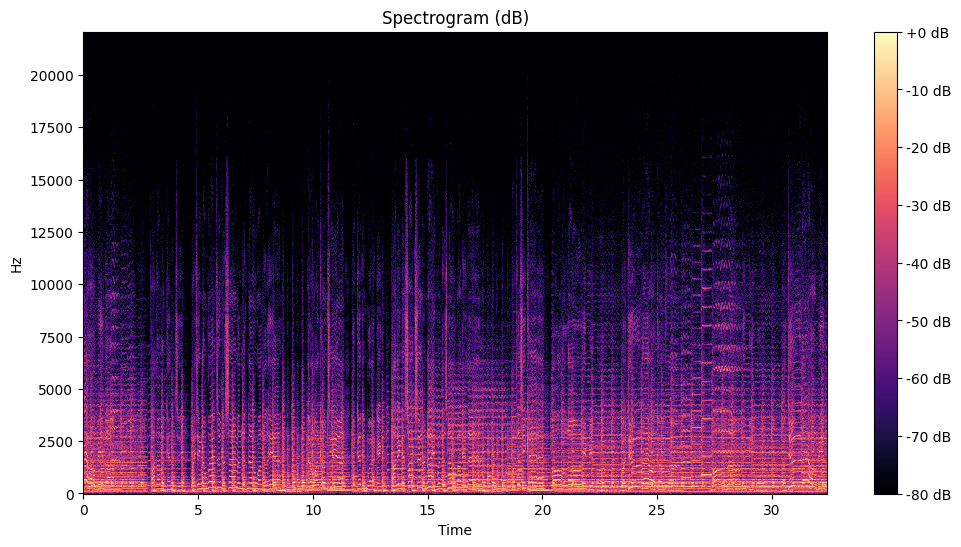

In [576]:
D = librosa.stft(y, n_fft=2048, hop_length=512) 
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

plt.figure(figsize=(12, 6))
librosa.display.specshow(S_db, sr=sr, hop_length=512,
                         x_axis='time', y_axis='hz', cmap='magma')
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram (dB)")
plt.show()

In [577]:

from scipy.ndimage import maximum_filter, generate_binary_structure, iterate_structure

neighborhood_size = (40, 40)  # (freq_bins, time_frames)
structure = generate_binary_structure(2, 1)
neighborhood = iterate_structure(structure, 10)

local_max = maximum_filter(S_db, footprint=neighborhood) == S_db

amplitude_thresh = -40  # dB
detected_peaks = local_max & (S_db > amplitude_thresh)

peak_freq, peak_time = np.where(detected_peaks)


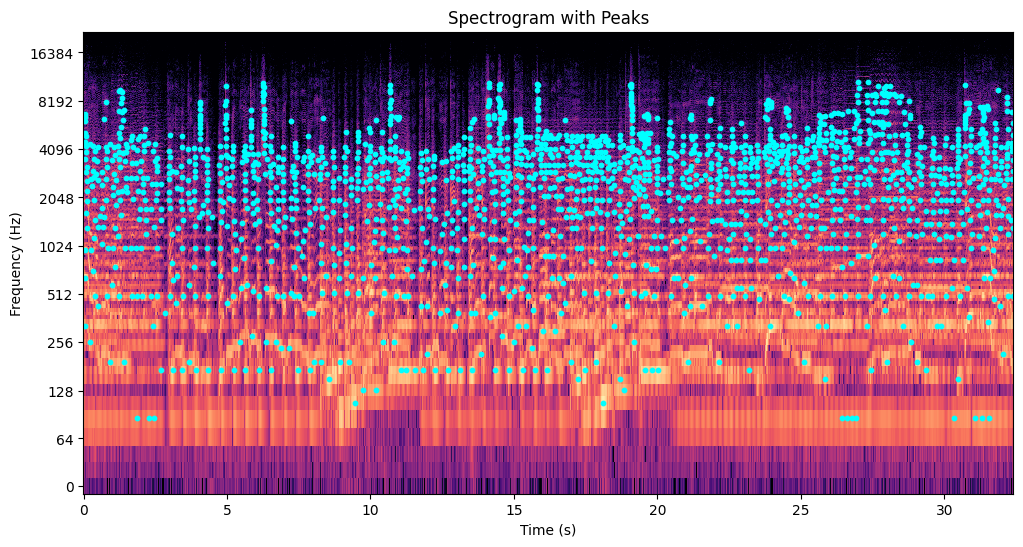

In [ ]:
# Plot
plt.figure(figsize=(12, 6))
librosa.display.specshow(S_db, sr=sr, hop_length=512, x_axis="time", y_axis="log", cmap="magma")
plt.scatter(peak_time * 512 / sr, peak_freq * (sr/2) / (S_db.shape[0]-1), color="cyan", s=10)
plt.title("Spectrogram with Peaks")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.show()

In [579]:
# shazam's peak finding is done by looking for a local maxima in a 2d neighbourhood
from scipy.ndimage import maximum_filter
neighborhood_size = (30, 30)
local_max = maximum_filter(spec_db, size=neighborhood_size) == spec_db
peaks = np.argwhere(local_max)

# filtering out the low frequencies
peaks = [(t, f) for f, t in peaks if spec_db[f, t] > -40]  # -40 dB threshold

peak_points = []
for (t, f) in peaks:
    time = t * hop_size / sr
    freq = f * sr / frame_size
    peak_points.append((time, freq))


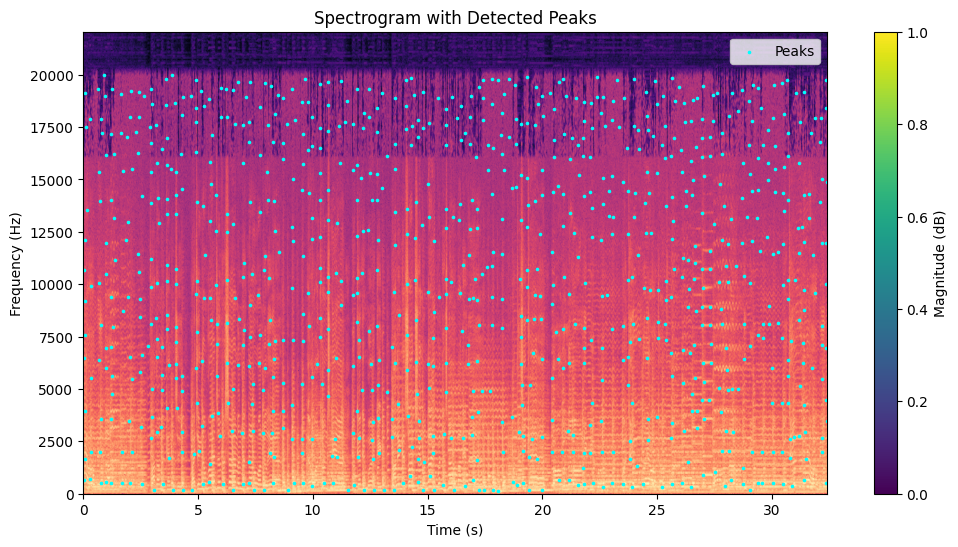

In [580]:
plt.figure(figsize=(12, 6))

# Plot spectrogram
plt.imshow(spec_db, origin="lower", aspect="auto", cmap="magma",
           extent=[0, len(y)/sr, 0, sr/2])

# Overlay peaks
times = [p[0] for p in peak_points]
freqs = [p[1] for p in peak_points]
plt.scatter(times, freqs, color="cyan", marker=".", s=10, label="Peaks")

plt.colorbar(label="Magnitude (dB)")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.title("Spectrogram with Detected Peaks")
plt.legend(loc="upper right")
plt.show()



RESOURCE
- https://www.audiolabs-erlangen.de/resources/MIR/FMP/C7/C7S1_AudioIdentification.html

Peaks in a spectrogram (local maxima) tend to be stable, even if there’s noise, MP3 compression, or background chatter.

A point (n0, k0) is a peak if its magnitude is greater than all neighbors within a rectangular neighborhood

∣X(n0​,k0​)∣≥∣X(n,k)∣∀(n,k)∈[n0​−τ:n0​+τ]×[k0​−κ:k0​+κ]

τ = how far you look in the time direction
κ = how far you look in the frequency direction

Bigger τ/κ = sparser constellation map (fewer peaks, only strong isolated ones)
After selecting peaks, you throw away magnitudes and keep only coordinates (time, frequency).
This looks like “stars in the night sky” → hence the name constellation map.

This is the bruteforce way to do this
for i in range(rows):
    for j in range(cols):
        val = spec_db[i, j]
        window = spec_db[i-τ:i+τ+1, j-κ:j+κ+1]
        if val == np.max(window):
            mark as peak

To do this in an efficient manner, we can use sliding window

very similar to LeetCode #239

1D Idea:
For each position, keep track of the maximum in the last k elements.
Use a deque that stores candidates in decreasing order.
Each element is inserted once and removed once → O(n)

2D Extension:
Step 1: Apply 1D sliding window max along rows (frequency axis).
→ You get an intermediate matrix where each value is the max over a frequency band.
Step 2: Apply 1D sliding window max along columns (time axis).
→ Now each value is the max over a full (τ, κ) rectangle

In [581]:
from collections import deque
import numpy as np

def sliding_window_max_1d(arr, k):
    dq = deque()
    result = []

    for i, val in enumerate(arr):
        # remove out-of-window indices
        while dq and dq[0] <= i - k:
            dq.popleft()

        # maintain decreasing order (monotonic queue)
        while dq and arr[dq[-1]] <= val:
            dq.pop()

        dq.append(i)

        # add max once we’ve filled the first window
        if i >= k - 1:
            result.append(arr[dq[0]])

    return np.array(result)  # make it numpy


def sliding_window_max_2d(matrix, win_row, win_col):
    rows, cols = matrix.shape

    # Step 1: row-wise max
    row_max = np.zeros((rows, cols - win_col + 1))
    for i in range(rows):
        row_max[i, :] = sliding_window_max_1d(matrix[i, :], win_col)

    # Step 2: column-wise max
    final_max = np.zeros((rows - win_row + 1, row_max.shape[1]))
    for j in range(row_max.shape[1]):
        final_max[:, j] = sliding_window_max_1d(row_max[:, j], win_row)

    return final_max


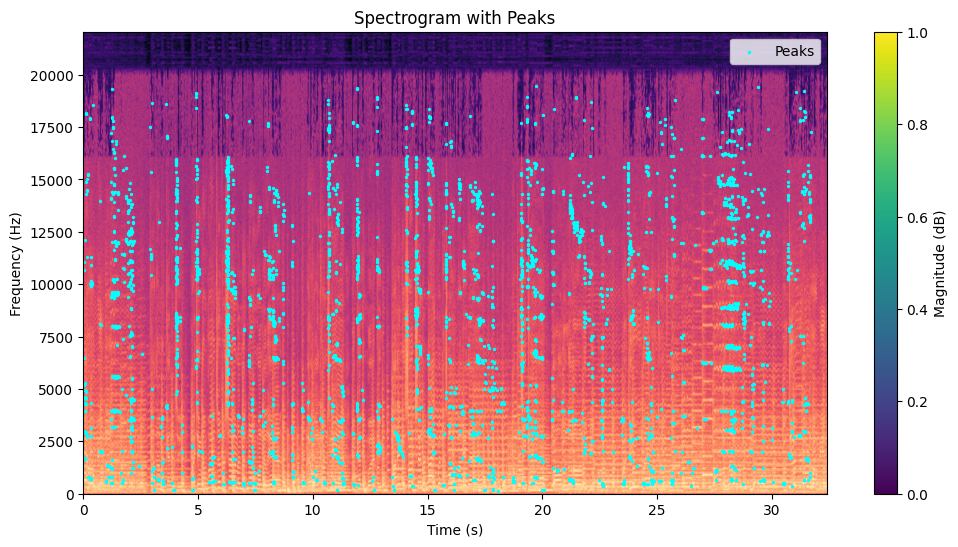

In [582]:
neighborhood_size = (30,30)
k,t = neighborhood_size
local_max = sliding_window_max_2d(spec_db, 2*k+1, 2*t+1)
amplitude_thresh = -30

def pad_to_shape(arr, target_shape):
    pad_rows = target_shape[0] - arr.shape[0]
    pad_cols = target_shape[1] - arr.shape[1]
    return np.pad(arr,
                  ((0, pad_rows), (0, pad_cols)),
                  mode="constant", constant_values=-np.inf)

# Apply padding FIRST
local_max_padded = pad_to_shape(local_max, spec_db.shape)

# Now shapes match - do the comparison
detected_peaks = (spec_db == local_max_padded) & (spec_db > amplitude_thresh)

peak_freq, peak_time = np.where(detected_peaks)
plt.figure(figsize=(12, 6))
plt.imshow(spec_db, origin="lower", aspect="auto", cmap="magma",
           extent=[0, len(y)/sr, 0, sr/2])
plt.scatter(peak_time * hop_size / sr,
            peak_freq * (sr/2) / (spec_db.shape[0]-1),
            color="cyan", s=2, marker="o", label="Peaks")
plt.colorbar(label="Magnitude (dB)")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.title("Spectrogram with Peaks")
plt.legend()
plt.show()

now that we are somewhat done with the peak finding, let's go on and connecting the peaks and store them as hashes.

#### Why are we doing this?
A single (freq, time) peak is fragile.
- Noise might add/remove peaks.
- If you cut the snippet at a different place, the absolute time value changes, so you can’t directly compare.

For each anchor peak:
Look ahead in time by a window (t_min to t_max seconds).
Pick a few target peaks that fall in this region.
Create a fingerprint (hash) from (f_anchor, f_target, Δt).
So each anchor generates multiple hashes.


The hash is built from:
- f_anchor (frequency of anchor)
- f_target (frequency of target)
- Δt = t_target - t_anchor

Each target zone has N peaks, they will make N-1 hashes, each from the anchor peak to all the other peaks in the target zone. 

From each anchor peak to other peak we will hash the following things -> (f_a, f_b, Δt)

Here f_a, f_b represents the bin of the frequency and not the raw frequency itself. 

For a normal song, we have 

Sampling rate = 44100 ( As humans can listen upto 20k and using nyquist frequency for sampling)

FFT Size N = 2048
Δf = Sr/N = 44100/2048 = 21.53 Hz

Using this we can calculate the bin that the frequencies f_a and f_b belong to and use that instead of the raw frequencies.

For ex, if f = 441Hz, then f_a = 441/21.53 = 20 

##### How many target zones are going to be there?
Each peak is going to act as a target zone, so we're going to have N target zone. Suppose in each target zone we have H hashes, there in total we're going to have 

N * H hashes. 
Which for a usual song comes out to be anywhere near 27k hashes to 120k hashes. 

##### Which Hashing method can we use?

- Tuple + Python Dict
key = (f_a, f_b, Δt)
hashmap[key] = (song_id, t_anchor)

By default python hashes this. This method won't result in any collisions but this methods downsides are memory usage. 

- Using a custom Hash
hash_val = (f_a << 20 || f_b << 10) | Δt 
f_a -> 10bits
f_b -> 10bits
Δt -> 9bits

total 29 bits. We can use a 32 bit number to represent them. We can also use a 64 bit number to represent more songs but for the sake of simplicity, let's stick with 32 for now. 

We can then use a hashmap then, to fingerprint the song in terms of hashes.

In [583]:
def encodehash(f_a, f_b, delta_t):
    f_a = int(f_a)
    f_b = int(f_b)
    delta_t = int(delta_t)
    hash_val = (f_a << (10 + 9)) | (f_b << 9) | delta_t

    hash_val &= 0xFFFFFFFF

    return hash_val
    #return (int(f1) << 20) | (int(f2) << 8) | int(delta_t)

def decodehash(hash_val):
    delta_t = hash_val & ((1 << 9) - 1)
    f_b = (hash_val >> 9) & ((1 << 10) - 1)
    f_a = (hash_val >> 19) & ((1 << 10) - 1)

    return (f_a, f_b, delta_t)

#### 1-D Sliding Window Implementation of Matching the peaks

In [591]:
# We'll be using about 5 peaks in each target zone

ZONE = 5
total_peaks = len(peak_points)
BIN_SIZE = 44100/(2*1024) # change these into variables

hashes = {}
count = 0

for i in range(0, total_peaks - ZONE):
    # choose the current as the anchor peak
    anchor = peak_points[i]
    f_a = anchor[0]/BIN_SIZE
    t_a = anchor[1]
    # loop over the peaks in the target zone
    # for a better method we can use sliding window approach instead

    # we need f_a, f_b and Δt
    for j in range(i+1, min(i+ZONE, total_peaks)):
        f_b = peak_points[j][0]/BIN_SIZE
        t_b = peak_points[j][1]
        delta_t = t_b - t_a

        # delta_t can't be bigger than 512
        
        if delta_t <= 0 or delta_t >= 512:
            count+=1
            continue

        hash_val = encodehash(f_a, f_b, delta_t)
        
        if hash_val not in hashes:
            hashes[hash_val] = []
        hashes[hash_val].append(t_a)

print(len(peak_points))
print(len(hashes))
print(sum(len(v) for v in hashes.values()))  # total (including duplicates)
print(f"No of filtered: {count}")



982
36
2609
No of filtered: 1299


Using a time based approach to match the peak points

In [ ]:

MIN_TIME_DELTA = 0.5  # Minimum time offset in seconds
MAX_TIME_DELTA = 1  # Maximum time offset in seconds
MAX_FREQ_DELTA = 300
FAN_OUT = 5

hashes = {}
count = 0

total_peaks = len(peak_points)
for i in range(total_peaks):
    f_a, t_a = peak_points[i] 

    # Reset a counter for each new anchor peak
    pairs_formed = 0

    for j in range(i + 1, total_peaks):
        f_b, t_b = peak_points[j]
        delta_t = t_b - t_a
        delta_f = f_b - f_a

        if MIN_TIME_DELTA <= delta_t <= MAX_TIME_DELTA and delta_f <= MAX_FREQ_DELTA:
            hash_val = encodehash(f_a, f_b, delta_t)

            if hash_val not in hashes:
                hashes[hash_val] = []
            hashes[hash_val].append((SONG_ID, t_a))

            pairs_formed += 1
            
            if pairs_formed >= FAN_OUT:
                break

        # Since the peaks are sorted by time, if you've passed the max
        # delta, you can break the inner loop and move to the next anchor.
        elif delta_t > MAX_TIME_DELTA:
            break

print(f"Found {len(peak_points)} peaks")
print(f"Generated {len(hashes)} unique hashes")
print(f"Total stored hashes (including duplicates): {sum(len(v) for v in hashes.values())}")
# print(hashes)

Found 982 peaks
Generated 0 unique hashes
Total stored hashes (including duplicates): 0
{}


In [586]:
# Saving to local database using pickle for now
# We can move onto using a better database like redis later
import pickle
DB_FILENAME = "fingerprints.pkl"

def save_hashes():
    with open(DB_FILENAME, 'ab') as f:  
        pickle.dump(hashes, f)
    print(f"Successfully appended {len(hashes)} fingerprints to {DB_FILENAME}")

def load_hashes():
    with open(DB_FILENAME, 'rb') as f:
        loaded_hashes = pickle.load(f)
    
    return loaded_hashes

In [587]:
# save_hashes()

## MATCHING

- Need to load the query the same way using librosa
- Need to run the same hashing function on the query
- Need the voting algorithm

In [588]:
import json
import numpy as np

# This is a custom converter class that teaches the json library
# how to handle NumPy's integer types.
class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NpEncoder, self).default(obj)

# --- Now, use this converter when you save your file ---

# Assume 'saved_hashes' is your dictionary.
# It might have NumPy numbers inside it.
db_filename_json = "fingerprints.json"

# Open the file in "write text" mode as before
with open(db_filename_json, 'w') as f:
    # Add the `cls=NpEncoder` argument to the dump function.
    # This tells json.dump() to use our special converter.
    json.dump(saved_hashes, f, indent=4, cls=NpEncoder)

print(f"Successfully saved fingerprints to {db_filename_json}")

Successfully saved fingerprints to fingerprints.json


In [589]:
# saved_hashes = load_hashes()
# print((saved_hashes))
# count1 = 0
# count2 = 0
# count3 = 0
# for i in range(len(hashes)):
#     if hashes[i] in saved_hashes:
#         song = saved_hashes[hashes[i]][0]
#         song = song[0]
#         if (song == 1):
#             count1+=1
#         elif (song == 2):
#             count2+=1
#         elif (song == 3):
#             count3+=1

# print(count1)
# print(count2)
# print(count3)

In [ ]:
import collections
import pickle

def load_hashes():
    with open('fingerprints.pkl', 'rb') as f:
        return pickle.load(f)

# 'hashes' is the variable you generated from fingerprinting your query song.
# Its structure is {hash: [(song_id, time), ...]}

# 1. Load the database
saved_hashes = load_hashes()

# --- DEBUGGING: Check for hash overlap ---

# Get the set of hash keys from your query and your database
query_hashes_set = set(sample_hashes.keys())
db_hashes_set = set(saved_hashes.keys())

# Find the intersection
common_hashes = query_hashes_set.intersection(db_hashes_set)

print(f"Total Hashes in Query: {len(query_hashes_set)}")
print(f"Total Hashes in Database: {len(db_hashes_set)}")
print(f"Number of Common Hashes Found: {len(common_hashes)}")

# If you want to see the actual hashes that match (optional)
# if common_hashes:
#     print(f"Example common hash: {list(common_hashes)[0]}")
# --- END DEBUGGING ---


# 2. Convert your query hashes to the correct format: {hash: time}
sample_hashes = {}
for hash_val, times in hashes.items():
    if times:
        # times[0] is a tuple like (song_id, time). We only want the time.
        # THE FIX IS HERE: Select the second element of the tuple.
        sample_hashes[hash_val] = times[0][1]

# print(sample_hashes)

# 3. Run the matching algorithm
histogram = collections.defaultdict(int)

# This loop will now work correctly
for sample_hash, t_sample in sample_hashes.items():
    if sample_hash in saved_hashes:
        for song_id, t_database in saved_hashes[sample_hash]:
            offset = t_database - t_sample
            key = (int(song_id), int(offset))
            histogram[key] += 1

# --- Find the Winning Song ---
if not histogram:
    print("No matches found.")
else:
    best_match = max(histogram.items(), key=lambda x: x[1])
    song_id, offset = best_match[0]
    num_votes = best_match[1]

    print(f"--- Match Found! ---")
    print(f"Best Match: Song ID {song_id}")
    print(f"Confidence (votes): {num_votes}")

Total Hashes in Query: 1437
Total Hashes in Database: 4080
Number of Common Hashes Found: 0
{816976385: np.int64(3), 817013249: np.int64(3), 817031681: np.int64(3), 817050113: np.int64(3), 817128449: np.int64(3), 1081031169: np.int64(7), 1081145345: np.int64(7), 1081201665: np.int64(7), 1022277633: np.int64(8), 1022046209: np.int64(8), 1139193857: np.int64(8), 1139486721: np.int64(8), 1139985921: np.int64(8), 1196865537: np.int64(8), 1197158401: np.int64(8), 1196609025: np.int64(8), 451407873: np.int64(9), 751300609: np.int64(9), 751471105: np.int64(9), 751613953: np.int64(9), 1262481409: np.int64(9), 1262127617: np.int64(9), 1262270465: np.int64(9), 1262387201: np.int64(9), 1394601985: np.int64(9), 1394248193: np.int64(9), 1394391041: np.int64(9), 1394507777: np.int64(9), 532789249: np.int64(10), 532829185: np.int64(10), 532905985: np.int64(10), 532945921: np.int64(10), 532984321: np.int64(10), 707377153: np.int64(10), 707417089: np.int64(10), 707493889: np.int64(10), 707533825: np.in